## Travel insurane prediction model

### Import packages

In [93]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

### Import csv

In [94]:
# Download latest version
path = kagglehub.dataset_download("tejashvi14/travel-insurance-prediction-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\liand\.cache\kagglehub\datasets\tejashvi14\travel-insurance-prediction-data\versions\4


### Create dataframe

In [95]:
# File is inside a downloaded folder (e.g. /home/user/.kagglehub/...)
df = pd.read_csv(os.path.join(path, "TravelInsurancePrediction.csv"))
df

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0
...,...,...,...,...,...,...,...,...,...,...
1982,1982,33,Private Sector/Self Employed,Yes,1500000,4,0,Yes,Yes,1
1983,1983,28,Private Sector/Self Employed,Yes,1750000,5,1,No,Yes,0
1984,1984,28,Private Sector/Self Employed,Yes,1150000,6,1,No,No,0
1985,1985,34,Private Sector/Self Employed,Yes,1000000,6,0,Yes,Yes,1


## EDA

#### Data Cleaning and validation

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1987 non-null   int64 
 1   Age                  1987 non-null   int64 
 2   Employment Type      1987 non-null   object
 3   GraduateOrNot        1987 non-null   object
 4   AnnualIncome         1987 non-null   int64 
 5   FamilyMembers        1987 non-null   int64 
 6   ChronicDiseases      1987 non-null   int64 
 7   FrequentFlyer        1987 non-null   object
 8   EverTravelledAbroad  1987 non-null   object
 9   TravelInsurance      1987 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 155.4+ KB


In [97]:
df.shape

(1987, 10)

In [98]:
df.columns

Index(['Unnamed: 0', 'Age', 'Employment Type', 'GraduateOrNot', 'AnnualIncome',
       'FamilyMembers', 'ChronicDiseases', 'FrequentFlyer',
       'EverTravelledAbroad', 'TravelInsurance'],
      dtype='object')

In [99]:
df.isna().sum()

Unnamed: 0             0
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

In [100]:
df.duplicated().sum()

np.int64(0)

In [101]:
df.nunique()

Unnamed: 0             1987
Age                      11
Employment Type           2
GraduateOrNot             2
AnnualIncome             30
FamilyMembers             8
ChronicDiseases           2
FrequentFlyer             2
EverTravelledAbroad       2
TravelInsurance           2
dtype: int64

In [102]:
df.dtypes

Unnamed: 0              int64
Age                     int64
Employment Type        object
GraduateOrNot          object
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance         int64
dtype: object

In [103]:
df = df.drop(columns=['Unnamed: 0'])

### Note:
No missing or duplicated values were found. The categorical variables need to be encoded for classification and correlation.

## EDA - Questions and graphs - Who is most likely to buy travel insurance?

#### Distribution by travel insurance

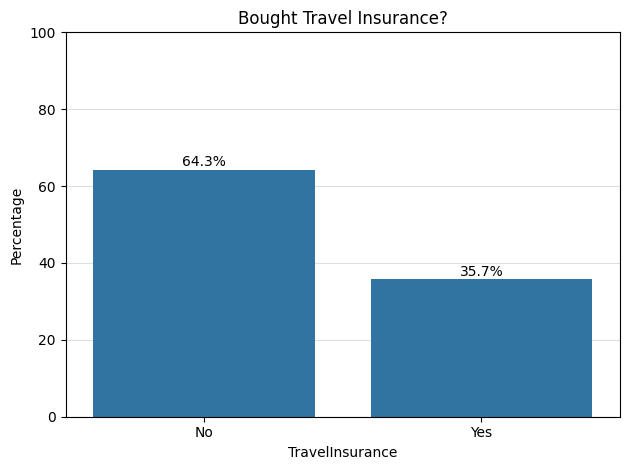

In [104]:
percentages = df["TravelInsurance"].value_counts(normalize=True).sort_index() * 100

data = pd.DataFrame({
    "TravelInsurance": percentages.index,
    "Percentage": percentages.values
})

# Plot actual percentages
sns.barplot(x="TravelInsurance", y="Percentage", data=data)

plt.xticks([0, 1], ["No", "Yes"])
plt.title("Bought Travel Insurance?")
plt.ylabel("Percentage")
plt.grid(axis="y", alpha=0.4)
plt.gca().set_axisbelow(True)
plt.ylim(0, 100)
plt.tight_layout()

# To print percentages on top of bars
for bar in plt.gca().patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    plt.text(x, height + 1, f'{height:.1f}%', ha='center')

plt.show()

The target is imbalanced, 64.3% did not buy insurance which can lead to biased predictions. I’ll address this using class weighting and evaluate the model with metrics that reflect balanced performance.

#### Age by travel insurance

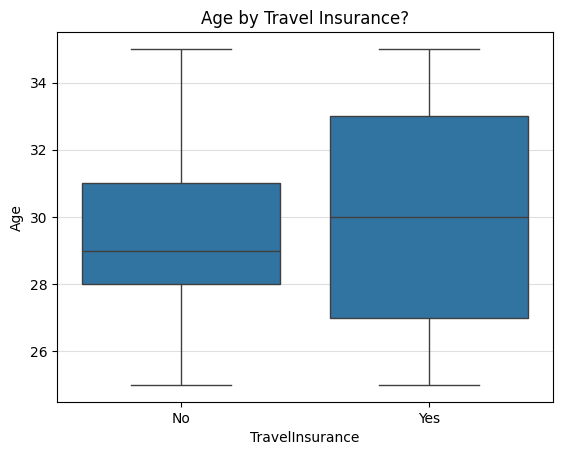

In [105]:
sns.boxplot(x="TravelInsurance", y="Age", data=df)
plt.title("Age by Travel Insurance?")
plt.xticks([0, 1], ["No", "Yes"])
plt.grid(axis="y", alpha=0.4)
plt.gca().set_axisbelow(True)
plt.show()

#### Frequent Flyers by Travel Insurance

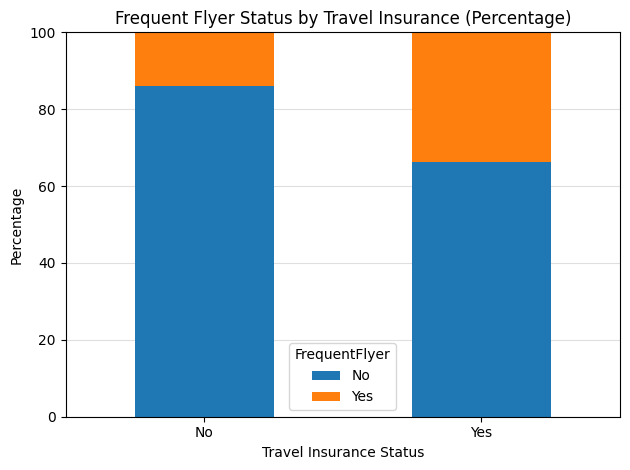

In [106]:
percentages_flyer = df.groupby("TravelInsurance")["FrequentFlyer"].value_counts(normalize=True).unstack() * 100

percentages_flyer.plot(kind="bar", stacked=True)

plt.title("Frequent Flyer Status by Travel Insurance (Percentage)")
plt.xlabel("Travel Insurance Status")
plt.ylabel("Percentage")
plt.xticks([0, 1], ["No", "Yes"], rotation=0) 
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.4)

plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()




#### Family size by travel insurance

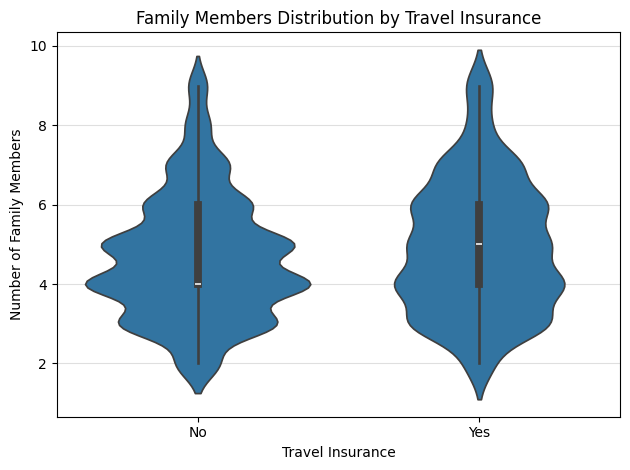

In [107]:
sns.violinplot(x="TravelInsurance", y="FamilyMembers", data=df)
plt.title("Family Members Distribution by Travel Insurance")
plt.xticks([0, 1], ["No", "Yes"])
plt.xlabel("Travel Insurance")
plt.ylabel("Number of Family Members")
plt.grid(axis="y", alpha=0.4)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

#### Graduate status by Travel insurance

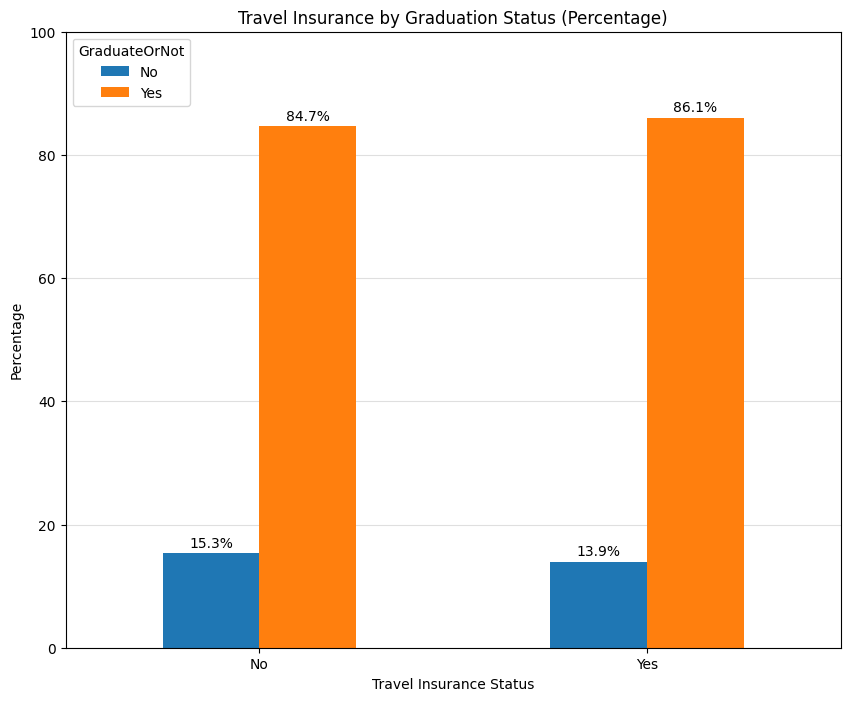

In [108]:
percentages_graduate = df.groupby("TravelInsurance")["GraduateOrNot"].value_counts(normalize=True).unstack() * 100

fig = percentages_graduate.plot(kind="bar", stacked=False, figsize=(10, 8)).get_figure()

plt.title("Travel Insurance by Graduation Status (Percentage)")
plt.xlabel("Travel Insurance Status")
plt.ylabel("Percentage")
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylim(0, 100) 
plt.grid(axis="y", alpha=0.4)
plt.gca().set_axisbelow(True)

for p in plt.gca().patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    plt.text(x, height + 1, f'{height:.1f}%', ha='center')

plt.show()



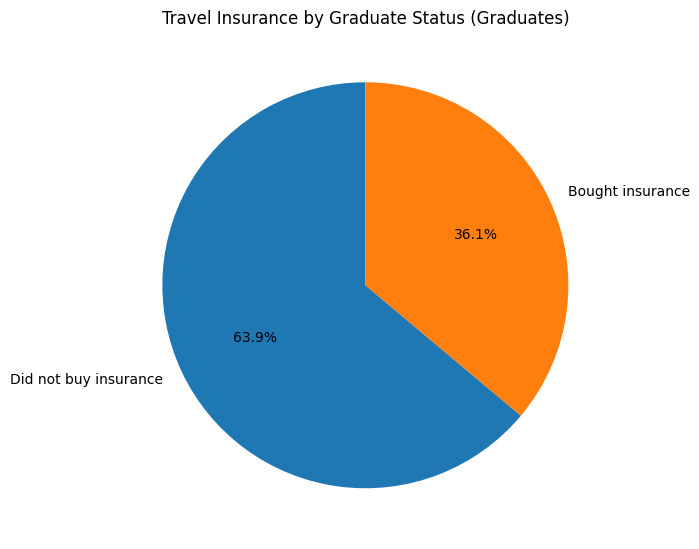

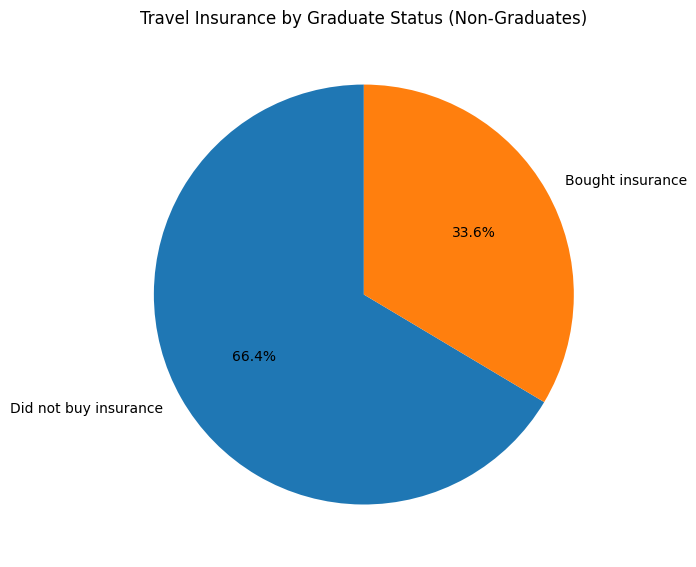

In [109]:
# Calculate the percentage of TravelInsurance for Graduates and Non-Graduates
percentages_graduate = df.groupby("GraduateOrNot")["TravelInsurance"].value_counts(normalize=True).unstack() * 100

# For Graduates
percentages_graduate.loc["Yes"].plot(kind="pie", labels=["Did not buy insurance", "Bought insurance"], 
                                     autopct='%1.1f%%', figsize=(7, 7), startangle=90)
plt.title("Travel Insurance by Graduate Status (Graduates)")
plt.ylabel("")
plt.tight_layout()
plt.show()

# For Non-Graduates
percentages_graduate.loc["No"].plot(kind="pie", labels=["Did not buy insurance", "Bought insurance"], 
                                    autopct='%1.1f%%', figsize=(7, 7), startangle=90)
plt.title("Travel Insurance by Graduate Status (Non-Graduates)")
plt.ylabel("")
plt.tight_layout()
plt.show()




#### Employment type by travel insurance

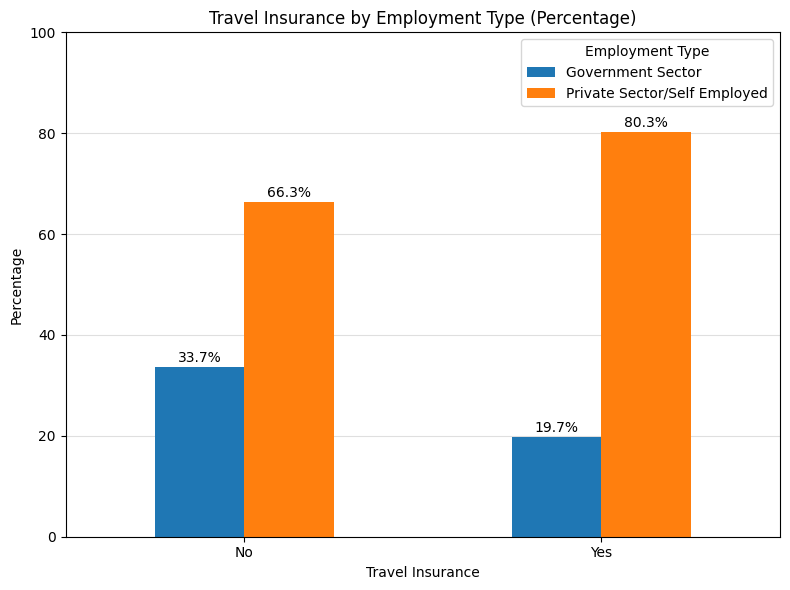

In [110]:
percentages_employment = df.groupby(["TravelInsurance", "Employment Type"]).size().unstack()
percentages_employment = percentages_employment.div(percentages_employment.sum(axis=1), axis=0) * 100

percentages_employment.plot(kind="bar", stacked=False, figsize=(8, 6))

plt.title("Travel Insurance by Employment Type (Percentage)")
plt.xlabel("Travel Insurance")
plt.ylabel("Percentage")
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.4)
plt.gca().set_axisbelow(True)

for p in plt.gca().patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    plt.text(x, height + 1, f'{height:.1f}%', ha='center')

plt.tight_layout()
plt.show()


#### Annual income by Travel insurance

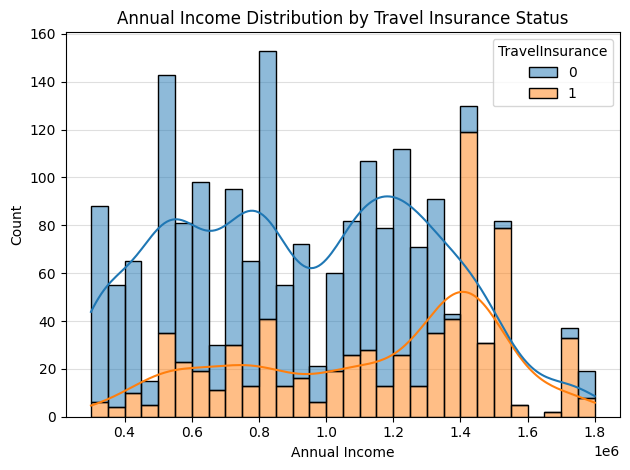

In [111]:
sns.histplot(df, x="AnnualIncome", hue="TravelInsurance", multiple="stack", bins=30, kde=True)

plt.title("Annual Income Distribution by Travel Insurance Status")
plt.xlabel("Annual Income")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.4)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()



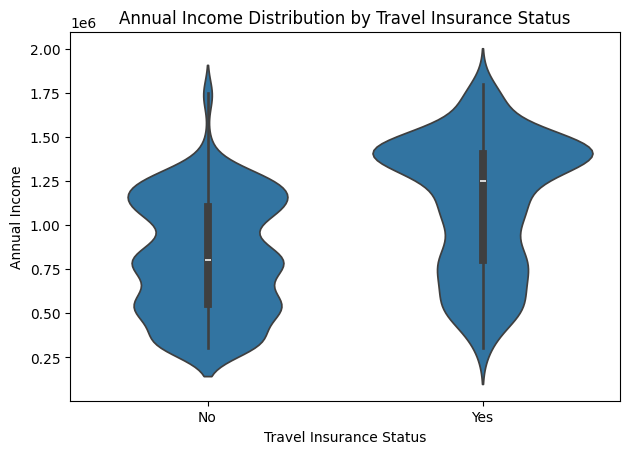

In [112]:
sns.violinplot(x="TravelInsurance", y="AnnualIncome", data=df)

plt.title("Annual Income Distribution by Travel Insurance Status")
plt.xlabel("Travel Insurance Status")
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylabel("Annual Income")
plt.tight_layout()
plt.show()


#### Ever travelled abroad by travel insurance

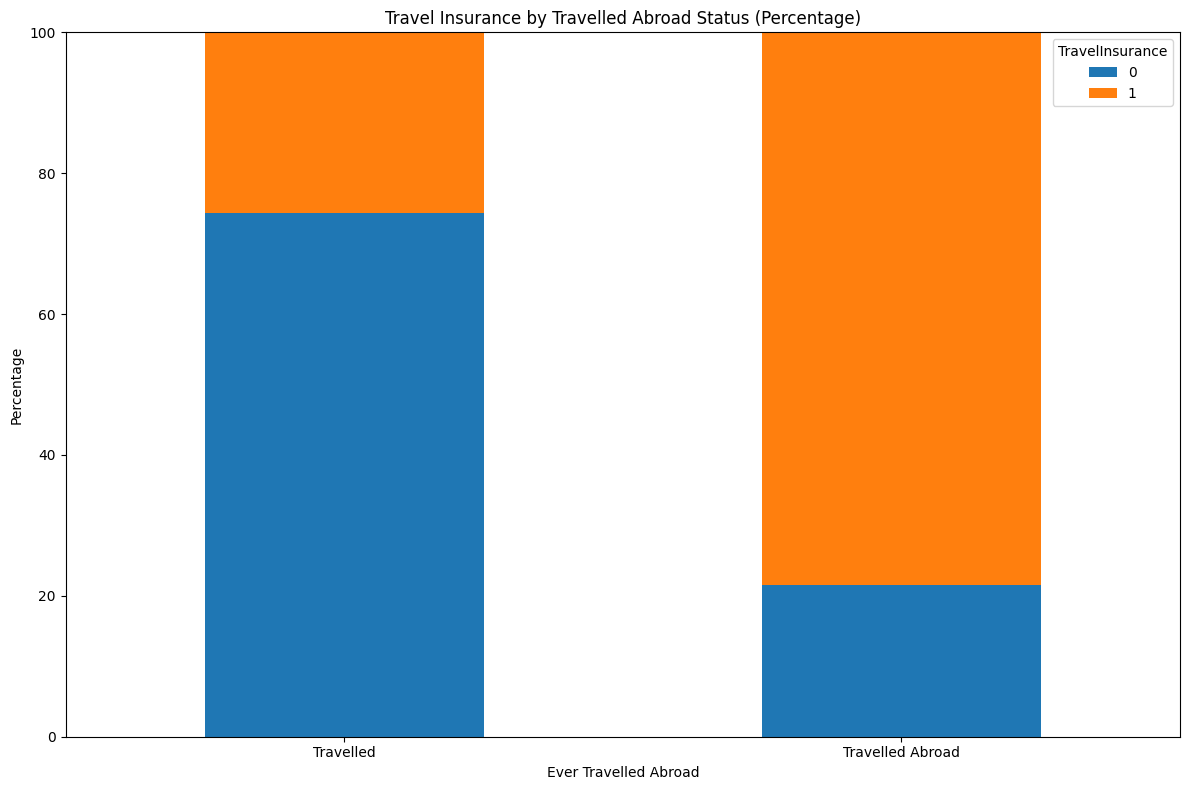

In [113]:
# Calculate the percentage of TravelInsurance by EverTravelledAbroad
percentages_travelled = df.groupby("EverTravelledAbroad")["TravelInsurance"].value_counts(normalize=True).unstack() * 100

percentages_travelled.plot(kind="bar", stacked=True, figsize=(12, 8))

plt.title("Travel Insurance by Travelled Abroad Status (Percentage)")
plt.xlabel("Ever Travelled Abroad")
plt.ylabel("Percentage")
plt.xticks([0, 1], ["Travelled", "Travelled Abroad"], rotation=0)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()




#### Chronic disease by travel insurance

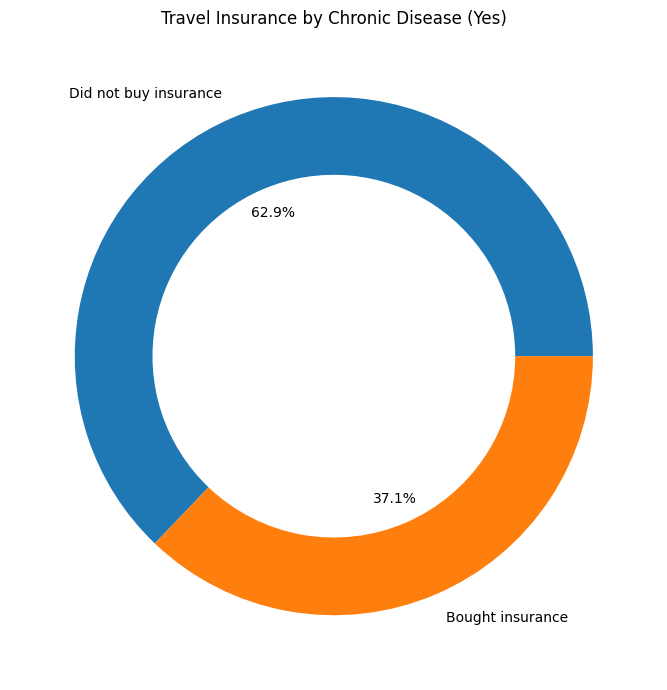

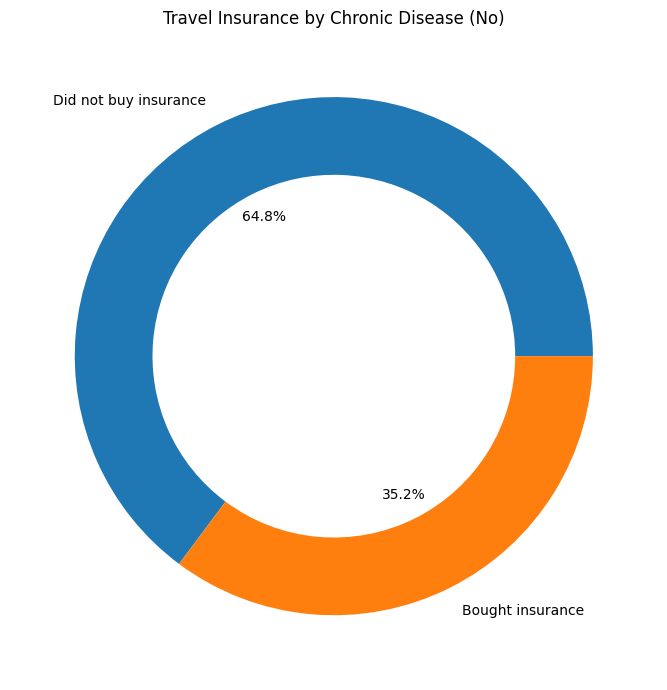

In [114]:
percentages_chronic = df.groupby("ChronicDiseases")["TravelInsurance"].value_counts(normalize=True).unstack() * 100

percentages_chronic.loc[1].plot(kind="pie", labels=["Did not buy insurance", "Bought insurance"], autopct='%1.1f%%', figsize=(7, 7), wedgeprops=dict(width=0.3))
plt.title("Travel Insurance by Chronic Disease (Yes)")
plt.ylabel("")
plt.tight_layout()
plt.show()

percentages_chronic.loc[0].plot(kind="pie", labels=["Did not buy insurance", "Bought insurance"], autopct='%1.1f%%', figsize=(7, 7), wedgeprops=dict(width=0.3))
plt.title("Travel Insurance by Chronic Disease (No)")
plt.ylabel("")
plt.tight_layout()
plt.show()



## Data Preprocessing

A great deal of the varables are categorical variables in string format. They need categorical encoding for a classification model.

In [115]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# List of binary categorical columns to label encode
binary_columns = ['GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']

# Apply label encoding to binary columns (Yes = 1, No = 0)
for col in binary_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [116]:
# Directly mapping categories to 1 and 0
df['Employment Type'] = df['Employment Type'].map({'Government Sector': 1, 'Private Sector/Self Employed': 0})


#### Renaming for clarity

In [117]:
df.rename(columns={'Employment Type': 'EmploymentType'}, inplace=True)

#### Correlation Matrix

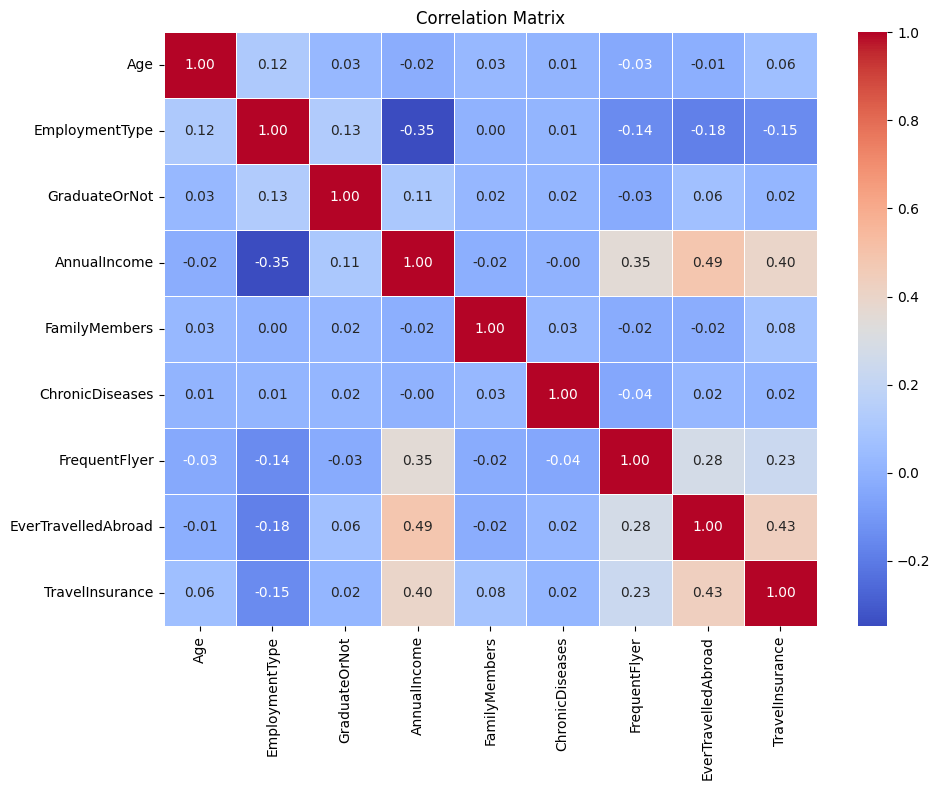

In [118]:
# Calculate the correlation matrix but only for numerical columns
correlation_matrix = df.corr()

# heatmap
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)


plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


### Random forest classification

In [119]:
# Features: independent variables
X = df.drop('TravelInsurance', axis=1)  # Drop the target column

# Target variable: dependent variable
y = df['TravelInsurance']

In [120]:
from sklearn.model_selection import train_test_split

# Stndard 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Train model
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)


#### Results

In [122]:
from sklearn.metrics import accuracy_score

# Model accuracy score
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print(classification_report(y_test, y_pred))

Accuracy: 0.8166
              precision    recall  f1-score   support

           0       0.82      0.91      0.87       257
           1       0.80      0.65      0.71       141

    accuracy                           0.82       398
   macro avg       0.81      0.78      0.79       398
weighted avg       0.81      0.82      0.81       398



#### Confusion Matrix

In [123]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)


[[234  23]
 [ 50  91]]


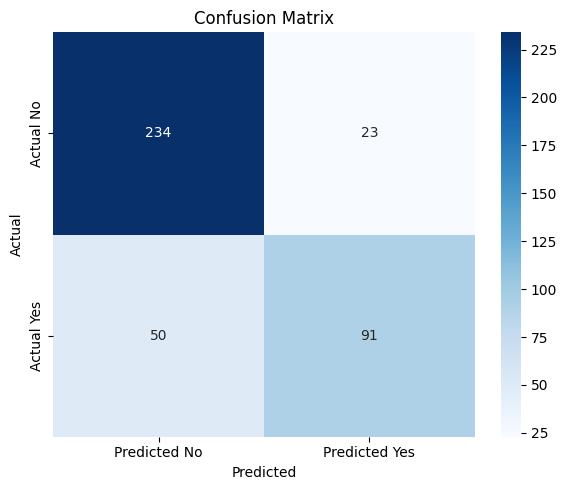

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()

plt.show()


### Random Forest with SMOTE

In [125]:
from imblearn.over_sampling import SMOTE

# Resample the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest with resampled data
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = rf.predict(X_test)


#### Results

In [126]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print(classification_report(y_test, y_pred))

Accuracy: 0.7889
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       257
           1       0.72      0.66      0.69       141

    accuracy                           0.79       398
   macro avg       0.77      0.76      0.76       398
weighted avg       0.79      0.79      0.79       398



#### Confusion Matrix

In [127]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)


[[221  36]
 [ 48  93]]


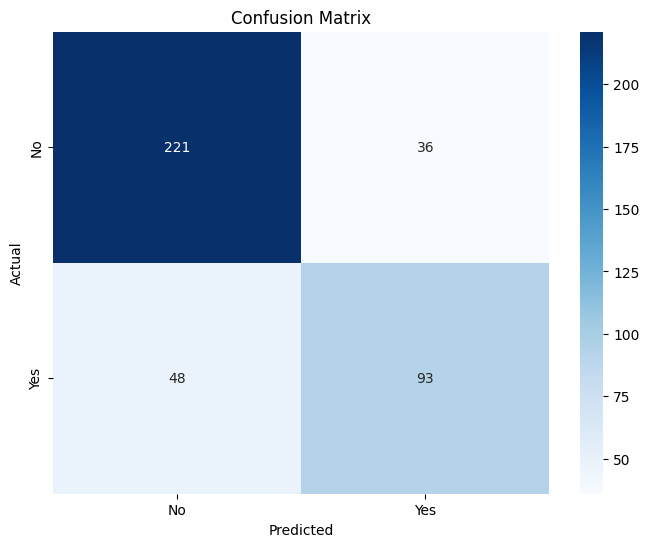

In [128]:
# Print confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Random Frest with GridSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
     'n_estimators': [100, 150, 200, 250, 300],
     'max_depth': [10, 20, 25, None],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 3, 4],
     'max_features': ['sqrt', 'log2', None],  # Change 'auto' to 'sqrt' or 'log2'
 }

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best Praeters
print(f"Best parameters found: {grid_search.best_params_}")

# Evaluate the best model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred)}")# Classification Report



Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy on Test Set: 0.8442211055276382
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       257
           1       0.99      0.57      0.72       141

    accuracy                           0.84       398
   macro avg       0.90      0.78      0.81       398
weighted avg       0.87      0.84      0.83       398



#### Results

In [ ]:
print(classification_report(y_test, y_pred))

#### Confusion Matrix

In [134]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)


[[256   1]
 [ 61  80]]


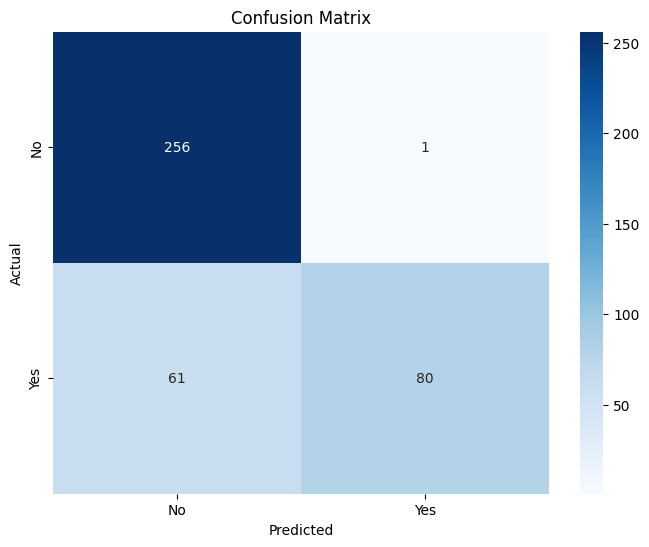

In [135]:
# Print confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Random Forest with predicted probabilities

In [ ]:
# Get predicted probabilities for "Yes" (1)
y_prob = rf.predict_proba(X_test)[:, 1]

# Adjust the decision threshold to increase recall
y_pred_adjusted = (y_prob >= 0.3).astype(int)

# Evaluate the adjusted model
from sklearn.metrics import classification_report

Accuracy on Test Set: 0.6809045226130653
              precision    recall  f1-score   support

           0       0.83      0.64      0.72       257
           1       0.54      0.76      0.63       141

    accuracy                           0.68       398
   macro avg       0.68      0.70      0.67       398
weighted avg       0.72      0.68      0.69       398



#### Results

In [ ]:
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred_adjusted)}")
print(classification_report(y_test, y_pred_adjusted))

#### Confusion Matrix

In [136]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)

print(cm)

[[164  93]
 [ 34 107]]


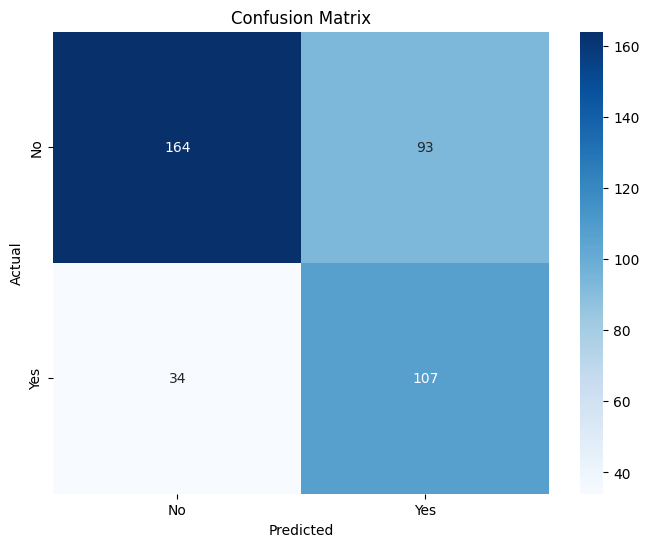

In [138]:
# Print confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### XGboost model

#### With SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Applied to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Resampled data
xgb_model_smote = XGBClassifier(random_state=34)  # No need for scale_pos_weight here
xgb_model_smote.fit(X_train_resampled, y_train_resampled)

# Prediction on original test set
y_pred_xgb_smote = xgb_model_smote.predict(X_test)



Accuracy: 0.8141
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       257
           1       0.77      0.67      0.72       141

    accuracy                           0.81       398
   macro avg       0.80      0.78      0.79       398
weighted avg       0.81      0.81      0.81       398



#### Results

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_smote):.4f}")
print(classification_report(y_test, y_pred_xgb_smote))

#### Confusion Matrix

In [144]:
cm = confusion_matrix(y_test, y_pred_xgb_smote)

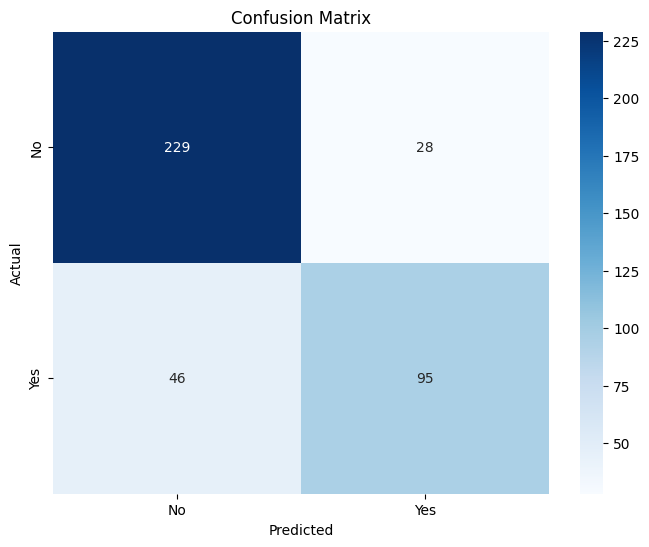

In [145]:
# Print confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### XGBoost with SMOTE and GridSearchCV

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Resample the training data with SMOTE
smote = SMOTE(random_state=35)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train XGBoost model with parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.1, 0.05],
}

xgb_model = xgb.XGBClassifier(random_state=32)

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

# Evaluate the best model
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Accuracy: 0.8417
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       257
           1       0.98      0.57      0.72       141

    accuracy                           0.84       398
   macro avg       0.89      0.78      0.80       398
weighted avg       0.87      0.84      0.83       398



#### results

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb))

#### Confusion Matrix

In [151]:
cm = confusion_matrix(y_test, y_pred_xgb)

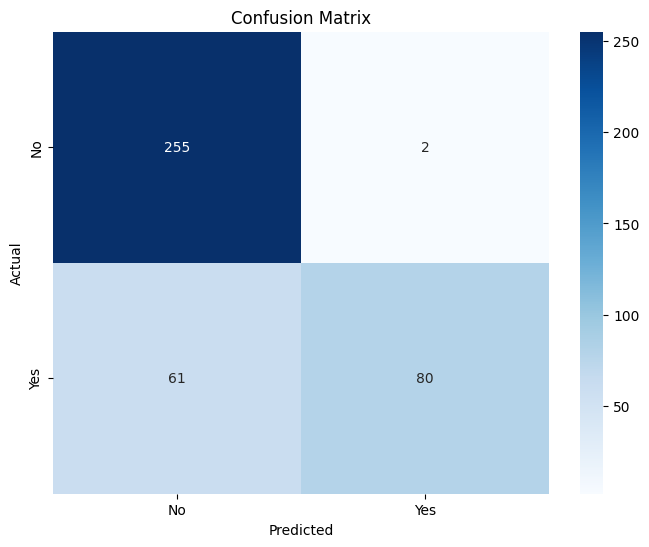

In [152]:
# Print confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()